In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import pylab as plt
from sklearn import decomposition
from sklearn import datasets
from sklearn import preprocessing

In [3]:
def resample(df, period):
    """Resample the frame df to period (in year)

    Input :
    -df : dataframe pandas with no index the time dimension exist as a year
        columns (column of integer)
    - period : integer : new wanted period

    Output : resampled frame
    """
    period = float(period)
    tuples = zip(df['code'],
                 (((df['year'].values) // period) * period) + period / 2.)
    df_copy = df.copy()
    df_copy.index = pd.MultiIndex.from_tuples(tuples)
    df_copy = df_copy.groupby(level=[0, 1]).mean().dropna(how='all')
    del df_copy['year']
    df_copy.index.names = ['code', 'year']
    return df_copy.sort_index()

In [14]:
def PCA_comp_and_proj(data, N_comp, normalize):
    # There are three different options to normalize... 
    if normalize:
        X = data
        for var in X.columns.levels[0]:
            X[:][var] -= X[:][var].mean().mean()
            X[:][var] /= X[:][var].std().mean()
        # X = preprocessing.normalize(data, axis=0)
        # X = data.apply(lambda x: (x - x.mean()) / x.std())
        X = pd.DataFrame(data=X, columns=data.columns, index=data.index)
    else: 
        X = data
    print "Data after the normalization"

    # Create the PCA object from sklearn
    pca = decomposition.PCA(n_components=N_comp)
    pca.fit(X)
    X_PCA = pca.transform(X)
    
    # plot the components
    f, axarr = plt.subplots(N_comp/2, 2, figsize=(12, 12))
    time_dim = data.columns.levels[1].values
    time_period = len(time_dim)
    for n in range(N_comp):
        i,j = n/2, n%2
        axarr[i, j].plot(time_dim, pca.components_[:, :time_period][n], '-o', label="GDP")
        axarr[i, j].plot(time_dim, pca.components_[:, time_period:][n], '-o', label="Gini")
        axarr[i, j].set_title(str(n + 1) + "ieme composante. Variance : "
                              + str(pca.explained_variance_ratio_[n]))
        axarr[i, j].legend()
        
    # print the projections of each country
    print pd.DataFrame(data=X_PCA, 
                       columns=["PC"+str(n+1) for n in range(N_comp)], 
                       index=X.index)
    
    return pca.components_

# Importing the data

Importing the GDP for sorting purpose

In [15]:
sorting_data = pd.read_csv("data_source/all_data.csv", usecols=["code", "GDP_PC_PWT"])
sorting_data = sorting_data.groupby('code').mean().dropna()

Variable choice and period choice

In [24]:
variables = ["code", "year", "GDP_growth_WB", "gini_before_taxe_OECD"]
period =  10

Importing the data to a frame, resampling it, removing any missing point and putting it in the good format

In [25]:
# Import the data and resample it
data = pd.read_csv("data_source/all_data.csv", usecols=variables)
re_data = resample(data, period)
re_data = re_data.dropna(how='any')
print re_data.info()
# Columns it
X = re_data.unstack('year').dropna(how='any')
# Sort the countries w.r.t the GDP per capita
X = pd.merge(X, sorting_data, how='left', left_index=True, right_index=True)
X = X.sort_values("GDP_PC_PWT", ascending=False)
del X['GDP_PC_PWT']
# print info
print "number of countries : ", len(X.index)
X.columns = pd.MultiIndex.from_tuples(X.columns.values)
X

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 126 entries, (AUS, 1995.0) to (USA, 2015.0)
Data columns (total 2 columns):
GDP_growth_WB            126 non-null float64
gini_before_taxe_OECD    126 non-null float64
dtypes: float64(2)
memory usage: 3.0+ KB
None
number of countries :  7


GDP_growth_WB                                          \
              1975      1985      1995      2005      2015   
code                                                         
USA       3.542590  3.142712  3.232118  1.817007  2.212394   
CAN       4.104115  2.881622  2.383138  2.093465  2.540007   
SWE       2.404783  2.295303  1.767169  2.024824  2.388010   
NLD       3.411778  1.960892  3.310680  1.609024  0.505000   
GBR       2.627822  2.622295  2.359377  1.846131  1.958358   
FIN       3.807710  3.622585  1.863191  2.028759  0.522214   
GRC       5.429861  0.777894  2.061355  2.771630 -4.891256   

     gini_before_taxe_OECD                                          
                      1975      1985      1995      2005      2015  
code                                                                
USA               0.314250  0.329067  0.353233  0.369967  0.388917  
CAN               0.308250  0.290267  0.284100  0.303300  0.306833  
SWE               0.216167  0.198667  0.215583  0.247167  0.271111  
NLD               0.245167  0.249833  0.268167  0.271222  0.268333  
GBR               0.256000  0.281000  0.317222  0.321383  0.330000  
FIN               0.249667  0.215375  0.224717  0.254783  0.257708  
GRC               0.437833  0.352667  0.355417  0.324046  0.320500

# PCA

Data after the normalization
           PC1       PC2       PC3       PC4       PC5       PC6
code                                                            
USA   0.208330 -2.981761  0.032038 -0.245278  0.247674  0.213447
CAN   0.960486 -0.929129  0.902447  0.132751 -0.724547 -0.117725
SWE   2.715332  1.508898 -0.348283  0.720962 -0.111282  0.188010
NLD   0.463273  0.985866 -0.865234 -0.813703 -0.390030 -0.015212
GBR   1.132197 -1.012450 -0.610210  0.330998  0.422544 -0.271588
FIN   0.992989  1.851859  0.926876 -0.381168  0.568638 -0.014400
GRC  -6.472608  0.576717 -0.037633  0.255438 -0.012997  0.017468


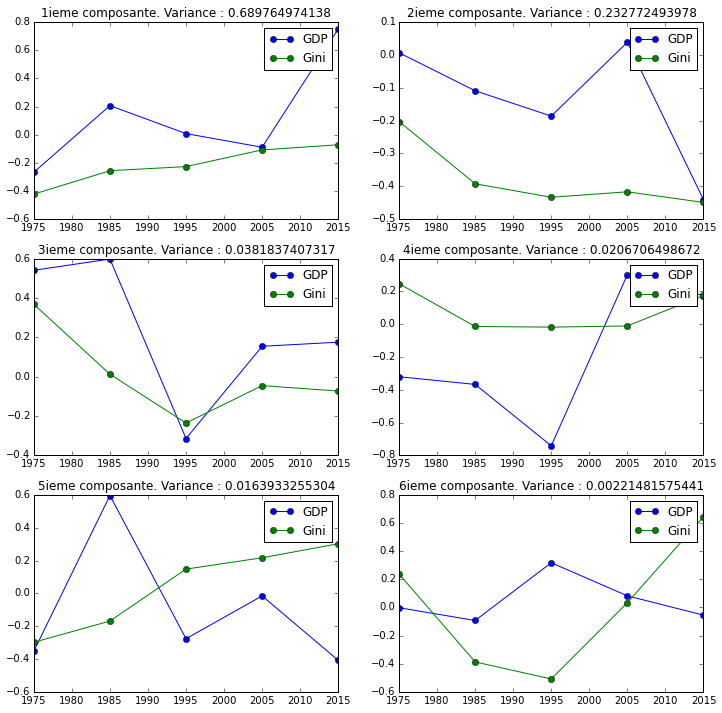

In [26]:
comp = PCA_comp_and_proj(X, 6, True)

Il existe plusieurs manières de normaliser les données qui donnent des résultats très différents : 
- Si on utilise preprocessing.normalize(axis=1) alors on normalise par ligne de données. C'est à dire que chaque vecteur (correspondant à un pays) resort avec une norme 2 égale à 1 i.e. le vecteur se retrouver sur la sphère unité
- Si on choisit preprocessing.normalize(axis=0) alors on normalise par colonne c'est-à-dire par variable. Après la normalisation, l'echelle (ou l'unité) de chaque variable s'est transformée de manière à ce que sa variance soit 1. Ainsi, chaque variable à une importance equivalente. 
- si on fait le truc maison lambda x: (x - x.mean()) / x.std() alors on normalise par variable en imposant en plus que les données soient centrées en l'origine. 

En traçant, PC1[growth] en fonction de PC1[gini] on devrait pouvoir retrouver la courbe de Kuznets, non ? 

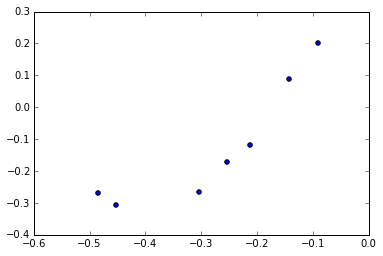

In [105]:
plt.scatter(comp[0][:7], comp[0][7:])